In [1]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras import backend as K
import os
import numpy as np
from keras.utils import np_utils
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# matplotlib.rcParams['figure.figsize'] = [10, 10]

Using TensorFlow backend.


In [2]:
# FOV_VALS = [30, 40, 50, 60, 70]
FOV_VALS = [70, 60, 50, 40, 30]

PARENT_DIR = '/media/johnkoo/data/stanford-dogs-dataset/'
val_dir = os.path.join(PARENT_DIR, 'val')
test_dir = os.path.join(PARENT_DIR, 'test')

NUM_CLASSES = 120

INPUT_SHAPE = (128, 128, 3)

BATCH_SIZE = 160

RUNS = 8

In [3]:
os.chdir(val_dir)
val_x = np.load('val-images.npy') / 255.
val_y = np.load('val-labels.npy')

os.chdir(test_dir)
test_x = np.load('test-images.npy') / 255.
test_y = np.load('test-labels.npy')

In [4]:
SUBSET_SIZE = 120

dogs = np.unique(val_y)
dogs_subset = np.random.choice(dogs, SUBSET_SIZE, replace=False)

val_ind = np.where(np.isin(val_y, dogs_subset))[0]
test_ind = np.where(np.isin(test_y, dogs_subset))[0]

val_x = val_x[val_ind, :, :, :]
test_x = test_x[test_ind, :, :, :]

val_y = val_y[val_ind]
test_y = test_y[test_ind]

y_dict = dict([(y, x) for x, y in enumerate(sorted(set(val_y)))])

y_val = np.asarray([y_dict[x] for x in val_y])
y_test = np.asarray([y_dict[x] for x in test_y])

y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [5]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [6]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [7]:
losses = []
accuracies = []

for fov in FOV_VALS:
    train_dir = os.path.join(PARENT_DIR, 'train', str(fov))
    
    for diverse_similar in ['diverse', 'similar']:
        os.chdir(train_dir)
        if diverse_similar not in os.listdir():
            os.mkdir(diverse_similar)
        train_x = np.load(diverse_similar + '-images.npy') / 255.
        train_y = np.load(diverse_similar + '-labels.npy')
        
        train_ind = np.where(np.isin(train_y, dogs_subset))[0]
        train_x = train_x[train_ind, :, :, :]
        train_y = train_y[train_ind]
        
        y_train = np.asarray([y_dict[x] for x in train_y])
        y_train = np_utils.to_categorical(y_train)
        
        os.chdir(diverse_similar)
        
        for i in range(RUNS):
            if str(i) not in os.listdir():
                os.mkdir(str(i))
            
            vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
            model = models.Sequential()
            model.add(vgg_conv)
            model.add(layers.Flatten())
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dense(SUBSET_SIZE, activation='softmax'))
            model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizers.SGD(lr=.001, momentum=.9), 
                          metrics=['acc'])
            
        
            tensorboard = TensorBoard(log_dir=os.path.join(train_dir, diverse_similar, str(i)))
            checkpoint = ModelCheckpoint(os.path.join(train_dir, diverse_similar, str(i)) + '/model-{epoch:04d}.hdf5', 
                                         save_weights_only=False,
                                         save_best_only=False,
                                         mode='auto', 
                                         period=1)
            earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=2)
            
            model.fit(train_x, y_train, 
                      validation_data=(val_x, y_val), 
                      epochs=100, 
                      batch_size=BATCH_SIZE, 
                      verbose=1,
                      shuffle=True, 
                      callbacks=[tensorboard, checkpoint, earlystopping])
            loss, accuracy = model.evaluate(test_x, y_test)
            losses.append(loss)
            accuracies.append(accuracy)
            
            K.clear_session()
            del model
            gc.collect()

Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 36s 6ms/step - loss: 4.8154 - acc: 0.0078 - val_loss: 4.7877 - val_acc: 0.0117
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.7063 - acc: 0.0280 - val_loss: 4.7605 - val_acc: 0.0160
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.4218 - acc: 0.0643 - val_loss: 4.7180 - val_acc: 0.0253
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.8744 - acc: 0.1195 - val_loss: 4.9244 - val_acc: 0.0320
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.3371 - acc: 0.2068 - val_loss: 4.6402 - val_acc: 0.0483
Epoch 6/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.6840 - acc: 0.3247 - val_loss: 4.7263 - val_acc: 0.0670
Epoch 7/100
4222/4222 [==============================] - 8s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/60

4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.8242 - acc: 0.0082 - val_loss: 4.7881 - val_acc: 0.0133
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.6908 - acc: 0.0265 - val_loss: 4.7280 - val_acc: 0.0183
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.3148 - acc: 0.0705 - val_loss: 4.5815 - val_acc: 0.0363
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.6033 - acc: 0.1657 - val_loss: 4.3447 - val_acc: 0.0597
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.8582 - acc: 0.3060 - val_loss: 4.2704 - val_acc: 0.0857
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.1064 - acc: 0.4547 - val_loss: 4.3082 - val_acc: 0.1050
Epoch 7/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1

6000/6000 [==============================] - 28s 5ms/step - loss: 3.8301 - acc: 0.1212 - val_loss: 4.3715 - val_acc: 0.0627
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.0572 - acc: 0.2560 - val_loss: 4.3788 - val_acc: 0.0740
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.3856 - acc: 0.3992 - val_loss: 4.2556 - val_acc: 0.0933
Epoch 7/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.5778 - acc: 0.5837 - val_loss: 4.6978 - val_acc: 0.1027
Epoch 8/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.8147 - acc: 0.0115 - val_loss: 4.7723 - val_acc: 0.0140
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.6199 - acc: 0.0408 - val_loss: 4.6772 - val_acc: 0.0240
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4

Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.3721 - acc: 0.6295 - val_loss: 4.0315 - val_acc: 0.1563
Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.8193 - acc: 0.0100 - val_loss: 4.7762 - val_acc: 0.0130
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.6694 - acc: 0.0317 - val_loss: 4.6880 - val_acc: 0.0213
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.2255 - acc: 0.0788 - val_loss: 4.6428 - val_acc: 0.0413
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.5282 - acc: 0.1768 - val_loss: 4.2388 - val_acc: 0.0710
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.6546 - acc: 0.3388 - val_loss: 4.1109 - val_acc: 0.0970
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/st

4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 27s 5ms/step - loss: 4.8261 - acc: 0.0077 - val_loss: 4.7823 - val_acc: 0.0117
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.7323 - acc: 0.0208 - val_loss: 4.7334 - val_acc: 0.0190
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.5032 - acc: 0.0478 - val_loss: 4.5982 - val_acc: 0.0273
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.8878 - acc: 0.1232 - val_loss: 4.1590 - val_acc: 0.0823
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.0794 - acc: 0.2558 - val_loss: 4.1604 - val_acc: 0.0967
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.2759 - acc: 0.4210 - val_loss: 3.8736 - val_acc: 0.1507
Epoch 7/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1

6000/6000 [==============================] - 28s 5ms/step - loss: 2.8335 - acc: 0.2977 - val_loss: 3.8911 - val_acc: 0.1423
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.9753 - acc: 0.4702 - val_loss: 3.5621 - val_acc: 0.1900
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.2317 - acc: 0.6610 - val_loss: 3.7017 - val_acc: 0.1910
Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.8196 - acc: 0.0082 - val_loss: 4.7726 - val_acc: 0.0130
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.6692 - acc: 0.0308 - val_loss: 4.6647 - val_acc: 0.0247
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.2323 - acc: 0.0790 - val_loss: 4.3963 - val_acc: 0.0663
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3

Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8229 - acc: 0.0087 - val_loss: 4.7770 - val_acc: 0.0157
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.7185 - acc: 0.0270 - val_loss: 4.6945 - val_acc: 0.0377
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.4250 - acc: 0.0678 - val_loss: 4.4883 - val_acc: 0.0557
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.7119 - acc: 0.1572 - val_loss: 3.8708 - val_acc: 0.1173
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.8492 - acc: 0.3055 - val_loss: 3.6023 - val_acc: 0.1610
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.0977 - acc: 0.4618 - val_loss: 3.4522 - val_acc: 0.2093
Epoch 7/100
6000/6000 [==============================] - 28s 5ms/st

6000/6000 [==============================] - 28s 5ms/step - loss: 4.8188 - acc: 0.0102 - val_loss: 4.7633 - val_acc: 0.0130
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.6794 - acc: 0.0320 - val_loss: 4.6406 - val_acc: 0.0333
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.2674 - acc: 0.0812 - val_loss: 4.2071 - val_acc: 0.0727
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.4237 - acc: 0.1973 - val_loss: 3.7142 - val_acc: 0.1363
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.5255 - acc: 0.3585 - val_loss: 3.4884 - val_acc: 0.1843
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.7618 - acc: 0.5393 - val_loss: 3.4430 - val_acc: 0.2230
Epoch 7/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.1324 - acc: 0.6877 - val_loss: 3.7624 - val_acc: 0.2003
Epoch 8/100
4222/4222 [==============================] - 7s 

Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.3272 - acc: 0.2173 - val_loss: 3.6718 - val_acc: 0.1537
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.4632 - acc: 0.3747 - val_loss: 3.2351 - val_acc: 0.2240
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.7529 - acc: 0.5415 - val_loss: 3.3953 - val_acc: 0.2303
Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.8320 - acc: 0.0067 - val_loss: 4.7789 - val_acc: 0.0137
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.7395 - acc: 0.0177 - val_loss: 4.7197 - val_acc: 0.0233
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.5307 - acc: 0.0553 - val_loss: 4.4750 - val_acc: 0.0500
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/st

Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.7589 - acc: 0.5317 - val_loss: 3.5851 - val_acc: 0.1903
Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.8212 - acc: 0.0097 - val_loss: 4.7632 - val_acc: 0.0180
Epoch 2/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.6575 - acc: 0.0345 - val_loss: 4.5917 - val_acc: 0.0427
Epoch 3/100
6000/6000 [==============================] - 28s 5ms/step - loss: 4.1075 - acc: 0.1002 - val_loss: 3.9089 - val_acc: 0.1247
Epoch 4/100
6000/6000 [==============================] - 28s 5ms/step - loss: 3.0764 - acc: 0.2527 - val_loss: 3.5986 - val_acc: 0.1780
Epoch 5/100
6000/6000 [==============================] - 28s 5ms/step - loss: 2.2108 - acc: 0.4212 - val_loss: 3.2796 - val_acc: 0.2340
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/st

In [8]:
fov_vals = np.repeat(FOV_VALS, [int(i) for i in np.ones(len(FOV_VALS)) * 2 * RUNS])

In [9]:
# diverse_similar = np.tile(['diverse', 'diverse', 'diverse', 'diverse', 
#                            'similar', 'similar', 'similar', 'similar'], len(FOV_VALS))
diverse_similar = np.tile(np.concatenate([np.repeat('diverse', RUNS), 
                                          np.repeat('similar', RUNS)]), 
                          len(FOV_VALS))

In [10]:
results_df = pd.DataFrame({'fov': fov_vals, 
                           'train_set_type': diverse_similar, 
                           'loss': losses, 
                           'accuracy': accuracies})
results_df.to_csv('/media/johnkoo/data/stanford-dogs-dataset/results-diversity.csv')

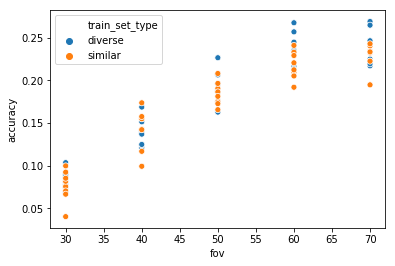

In [11]:
sns.scatterplot(x='fov', y='accuracy', hue='train_set_type', data=results_df)

In [14]:
results_agg_df = (
    results_df.
    groupby(['fov', 'train_set_type']).
    agg({'accuracy': ['mean', 'std']}))

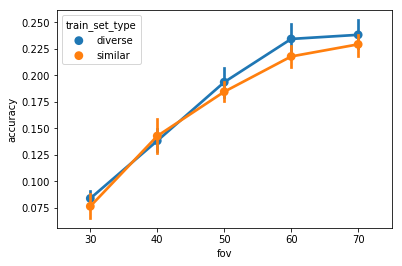

In [15]:
sns.pointplot(x='fov', y='accuracy', hue='train_set_type', data=results_df)